# AI Learns to play Dino game!

In [1]:
# Importing Libraries

# Bread and butter
import numpy as np
import matplotlib.pyplot as plt

# Importing Selenium to control the browser
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

# To use our keyboard
import pyautogui

# TO help me become Doctor Strange
import time

# Because I can't do Image processing myself
import cv2 

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Pur environment class which is used to play the game
class Environment():

    def __init__(self, device="cpu", chrome_path=".//Driver/chromedriver.exe"):
        self.done = False
        self.device = device
        self.initialize_chrome(chrome_path)
        
    def initialize_chrome(self, chrome_path):
        chrome_options = Options()
        chrome_options.add_argument("start-maximized")
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        self.driver = webdriver.Chrome(chrome_path, chrome_options=chrome_options)
        
    def reset(self, game_url="chrome://dino"):
        try:
            self.driver.get(game_url)
        except:
            pass
    
    def start(self):
        pyautogui.press("up")

    # Hard stop
    def close_all(self):
        self.driver.close()
        self.driver.quit()
        try:
            os.system("cmd /c taskkill /F /IM chromedriver.exe")
        except:
            print("No tasks found!")
    

    def get_screenshot(self, screenshot_path=".//Screenshots/"):
        current_state = []
        for i in range(1, 5):
            file_name = screenshot_path + str(i) + '.jpg'
            screenshot = pyautogui.screenshot(region=(0, 400, 1920, 330))
            screenshot.save(file_name)
            image_tensor = self.process_image(file_name)
            current_state.append(image_tensor)
        current_state = torch.cat(current_state).unsqueeze(0).to(self.device)
        return current_state

    def process_image(self, image_file):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image[image>255] = 255
        image = cv2.resize(image, (256, 128))
        image = cv2.Canny(image, threshold1=100, threshold2=200)
        image = np.reshape(image, (1, 256, 128))
        return self.image_to_tensor(image)

    def image_to_tensor(self, image):
        image = image.astype(np.float32)
        image_tensor = torch.from_numpy(image)
        image_tensor = image_tensor.to(self.device, dtype=torch.float32)
        return image_tensor


    def jump(self):
        pyautogui.keyDown("up")
        time.sleep(0.2)
        pyautogui.keyUp("up")


    def duck(self):
        pyautogui.keyDown("down")
        time.sleep(0.25)
        pyautogui.keyUp("down")


    def do_nothing(self):
        time.sleep(0.25)


    def take_action(self, action):
        reward = 1
        if action == 0:
            self.jump()
        elif action == 1:
            self.duck()
        elif action == 2:
            self.do_nothing()
        
        state = self.get_screenshot()

    def view_screenshots(self, images):
        # images are of the shape (1, 4, 256, 128)
        images = torch.reshape(images, shape=(4, 128, 256))
        
        fig, ax = plt.subplots(2, 2, figsize=(14, 14))
        x = 0
        for i in range(2):
            for j in range(2):
                ax[i][j].imshow(images[x], cmap="gray")
                ax[i][j].set_title(f"Screenshot #{x}")
                x += 1
        
                
    def end_of_episode(self):
        return self.driver.execute_script("return Runner.instance_.crashed")

In [3]:
class DinoNetwork(nn.Module):
    def __init__():
        super(DinoNetwork, self).__init__()
        # First COnv Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(512)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 3),
            nn.Sigmoid()
            
        )

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        # We will now flatten the layers
        # Calculated using this below line
        x = self.flatten(start_dim=1, end_dim=-1)
        # print(f"After flattening, shape is {x.shape}")
        x = self.fc1(x)
        x = self.fc2(x)
        return x

def init__weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        # Kaimig Uniform initialization is used for Relu Activation. It's mostly known as 'He weight initialization'.
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')



In [4]:
# Defining Constants
batch_size = 128

# Gamma (Discount rate for future rewards)
gamma = 0.95

# Exploration rate
epsilon_start = 1

# Decay rate for Epsilon
epsilon_decay = 0.995

# Minimum Epsilon
epsilon_min = 0.1

# Updating the Target Q Network after these many episodes
target_update = 30

# Selecting the device for the iterations
device = torch.device('cuda' if torch.cuda_is_available() else 'cpu')

# Setting loss criteria
criterion = nn.MSELoss()

#

AttributeError: module 'torch' has no attribute 'cuda_is_available'

D:\Programming\Python\Environments\py3.7_envs\AiPlaysDino\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  


Episode ended? False
torch.Size([1, 4, 256, 128])


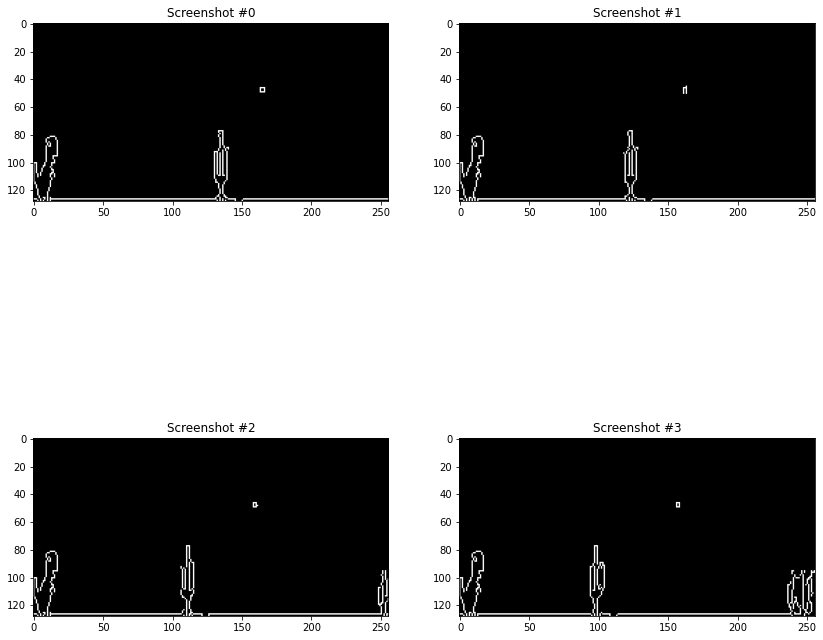

In [7]:
env = Environment()
env.reset()
env.start()
time.sleep(2)
env.jump()
print(f"Episode ended? {env.end_of_episode()}")

print(images.shape)
env.view_screenshots(images)
time.sleep(2)
env.duck()
time.sleep(2)
images = env.get_screenshot()